In [1]:
! pip install kaggle

In [2]:
import kagglehub

path = path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)


100%|██████████| 1.99M/1.99M [00:00<00:00, 3.35MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2


In [3]:
# Importing Dependencies
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
csv_data = path+"/twitter_training.csv"
print(csv_data)


# Data Processing
# loading the data from csv file to pands datafram
twitter_data = pd.read_csv(csv_data, encoding = 'ISO-8859-1')

twitter_data.head()


/root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2/twitter_training.csv


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
column_name = ['Tweet_ID', 'Entity', 'target', 'text']
twitter_data = pd.read_csv(csv_data, names=column_name, encoding='ISO-8859-1')
twitter_data.head()

,Tweet_ID,Entity,target,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
twitter_data.drop(columns=['Tweet_ID', 'Entity'], inplace=True)
twitter_data.head()

,target,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [11]:
twitter_data.replace({'target': {'Positive': 2, 'Negative': 0, 'Neutral': 1}}, inplace=True)
twitter_data.head()
print(twitter_data)



      target                                               text
0          2  im getting on borderlands and i will murder yo...
1          2  I am coming to the borders and I will kill you...
2          2  im getting on borderlands and i will kill you ...
3          2  im coming on borderlands and i will murder you...
4          2  im getting on borderlands 2 and i will murder ...
...      ...                                                ...
74677      2  Just realized that the Windows partition of my...
74678      2  Just realized that my Mac window partition is ...
74679      2  Just realized the windows partition of my Mac ...
74680      2  Just realized between the windows partition of...
74681      2  Just like the windows partition of my Mac is l...

[74682 rows x 2 columns]


In [13]:
twitter_data.to_csv("/cleaned_twitter_data.csv", index=False, encoding="utf-8")

*Stemming*

In [17]:
# Stemming
port_stem = PorterStemmer()

def stemming(content):
        stemmed_content = str(content)
        stemmed_content = re.sub('[^a-zA-Z]', ' ', stemmed_content)
        stemmed_content = stemmed_content.lower()
        stemmed_content = stemmed_content.split()
        stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stopwords.words('english')]
        return ' '.join(stemmed_content)

# Apply stemming to the 'text' column
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

twitter_data.head()

,target,text,stemmed_content
0,2,im getting on borderlands and i will murder yo...,im get borderland murder
1,2,I am coming to the borders and I will kill you...,come border kill
2,2,im getting on borderlands and i will kill you ...,im get borderland kill
3,2,im coming on borderlands and i will murder you...,im come borderland murder
4,2,im getting on borderlands 2 and i will murder ...,im get borderland murder


In [21]:
# Separating the data and label
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

# Splitting the data to training data and test data
Y = Y.astype(str)  # Convert Y to string type
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [22]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [23]:

# Save the vectorizer
import pickle
with open('vectorizer.sav', 'wb') as f:
    pickle.dump(vectorizer, f)

In [52]:
# Training the machine Learning Model - Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)


LogisticRegression(max_iter=1000)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.85      0.79      4509
           1       0.78      0.73      0.76      3664
           2       0.78      0.79      0.78      4166
  Irrelevant       0.81      0.67      0.73      2598

    accuracy                           0.77     14937
   macro avg       0.78      0.76      0.77     14937
weighted avg       0.77      0.77      0.77     14937



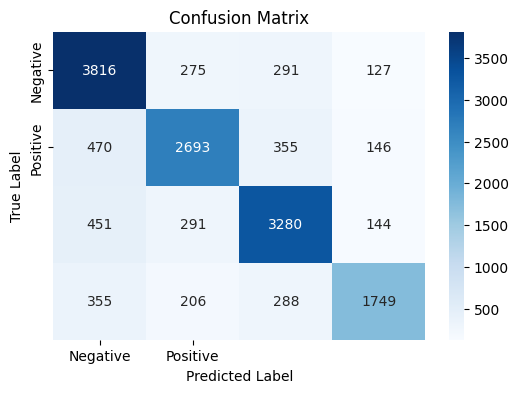

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Predictions on test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability scores for ROC

# 1.Classification Report (Accuracy, Precision, Recall, F1-score)
print("Classification Report:\n", classification_report(Y_test, y_pred))

# 2.Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [25]:
# Model Evaluation - Accuracy Score
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print("Accuracy Score on the training data:", training_data_accuracy)

Accuracy Score on the training data: 0.8302284710017575


In [26]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print("Accuracy Score on the test data:", test_data_accuracy)

Accuracy Score on the test data: 0.7724442659168508


In [27]:
# Saving the trained Model
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [43]:

# Function for predicting sentiment of custom text
def predict_sentiment(text):

    loaded_model = pickle.load(open('trained_model.sav', 'rb'))
    vectorizer = pickle.load(open('vectorizer.sav', 'rb'))

    stemmed_text = stemming(text)
    text_vectorized = vectorizer.transform([stemmed_text])
    prediction = loaded_model.predict(text_vectorized)

    sentiment_class = int(prediction[0])
    # print(sentiment_class)

    # Map prediction to sentiment labels
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

    return sentiment_mapping.get(sentiment_class, "Unknown")


In [58]:

custom_text = "Check out this epic streamer!."
sentiment = predict_sentiment(custom_text)
print(sentiment)

1
Neutral
